In [1]:
import glob
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import os
import pathlib
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"tanvipenumudy","key":"060d385c034df0a67a1402a323b1867e"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:32<00:00, 43.0MB/s]
100% 1.21G/1.21G [00:32<00:00, 39.5MB/s]


In [7]:
!ls

 data1.csv   data.csv					    kaggle.json
 data2.csv   gtzan-dataset-music-genre-classification.zip   sample_data
 data3.csv  'kaggle (1).json'
 data4.csv  'kaggle (2).json'


In [9]:
!unzip "gtzan-dataset-music-genre-classification.zip" -d /tmp

Archive:  gtzan-dataset-music-genre-classification.zip
replace /tmp/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /tmp/Data/features_30_sec.csv  
  inflating: /tmp/Data/features_3_sec.csv  
  inflating: /tmp/Data/genres_original/blues/blues.00000.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00001.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00002.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00003.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00004.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00005.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00006.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00007.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00008.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00009.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00010.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00011.wav  
  inflating: /tmp/Dat

In [10]:
import os
print(len(os.listdir('/tmp/Data/genres_original')))
print(len(os.listdir('/tmp/Data/genres_original/hiphop')))
print(len(os.listdir('/tmp/Data/genres_original/jazz')))

10
100
100


In [ ]:
temp = '/tmp/Data/genres_original/metal/metal.00083.wav'
x, sr = librosa.load(temp)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661504,) 22050


In [ ]:
import IPython.display as ipd
ipd.Audio(temp)

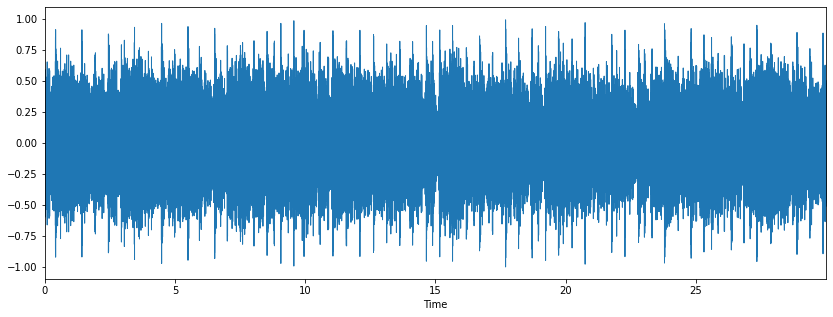

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

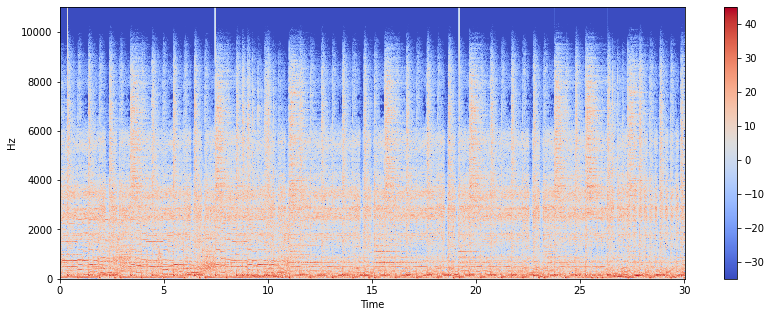

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [14]:
import csv

In [12]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [17]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/tmp/Data/genres_original/{g}'):
        songname = f'/tmp/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [22]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00007.wav,0.307955,0.131822,1451.667066,1577.270941,2954.836760,0.061442,-179.347149,136.469013,-26.673135,39.984244,5.304419,10.928610,-20.564827,8.511156,-11.357249,-3.468347,-8.419937,-6.949716,-3.539139,-8.041618,-8.960675,-8.426084,-10.568936,-10.784516,-4.690677,-8.630722,blues
1,blues.00055.wav,0.432937,0.157742,2032.001859,1976.383235,4023.561440,0.113119,-98.743446,104.793649,-35.098252,60.701811,-2.833250,22.234495,-7.831172,19.035851,-11.573603,17.018518,-5.376152,12.200969,-9.956366,0.353348,-4.268689,6.133699,-4.822605,1.500582,-1.493840,3.509201,blues
2,blues.00070.wav,0.322809,0.106137,2159.392000,2130.224381,4684.529188,0.098348,-133.015971,105.734450,-22.149999,41.831103,-26.984577,19.115876,-26.562516,19.230763,-15.338012,6.986511,-10.808672,6.796417,-11.725246,4.393898,-6.027783,1.961996,-12.309117,3.256355,-8.804639,-3.371867,blues
3,blues.00001.wav,0.340914,0.095948,1530.176679,2039.036516,3550.522098,0.056040,-207.501685,123.991259,8.955128,35.877647,2.907321,21.510467,-8.560437,23.370686,-10.099661,11.900497,-5.555638,5.376327,-2.231760,4.220140,-6.012149,0.927997,-0.731124,0.295072,-0.283518,0.531216,blues
4,blues.00064.wav,0.332650,0.117432,2553.361183,2280.266170,5148.375700,0.146833,-85.108766,88.799706,-16.312861,59.226771,-35.976449,14.388841,-22.294800,9.654231,-14.818461,11.175134,-14.799717,8.472941,-19.585276,6.412785,-13.775700,6.113826,-13.147978,3.931494,-7.612430,3.752393,blues


In [23]:
data.shape

(900, 28)

In [24]:
data = data.drop(['filename'],axis=1)

In [25]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(675, 26) (225, 26) (675,) (225,)


In [41]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([71, 75, 72, 78, 79, 73, 75, 76, 76]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([29, 25, 28, 22, 21, 27, 25, 24, 24]))


In [43]:
from keras.utils import to_categorical

In [44]:
#One-hot encoding 
print("Before:", y_train.shape)
print("Before:", y_test.shape)
y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)
print("After: ", y_train.shape)
print("After: ", y_test.shape)

Before: (675,)
Before: (225,)
After:  (675, 9)
After:  (225, 9)


In [53]:

from keras import models
from keras import layers

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))                           
model.add(Dense(256, activation='relu'))   
model.add(Dense(128, activation='relu'))                           
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [54]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
history = model.fit(X_train,y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=128)

Epoch 1/100
6/6 [==============================] - 0s 25ms/step - loss: 2.1018 - accuracy: 0.2815 - val_loss: 1.8950 - val_accuracy: 0.3467
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 1.8427 - accuracy: 0.3378 - val_loss: 1.6635 - val_accuracy: 0.4044
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.5977 - accuracy: 0.4178 - val_loss: 1.4581 - val_accuracy: 0.5022
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.3899 - accuracy: 0.5081 - val_loss: 1.2782 - val_accuracy: 0.5244
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 1.2147 - accuracy: 0.5674 - val_loss: 1.1661 - val_accuracy: 0.5733
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0850 - accuracy: 0.6267 - val_loss: 1.1496 - val_accuracy: 0.5822
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9787 - accuracy: 0.6726 - val_loss: 1.1171 - val_accuracy: 0.6178
Epoch 8/100
6/6 [=========